In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
import tensorflow as tf

In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions  = readTextFile("/content/drive/MyDrive/ai/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [4]:
print(len(captions))



40460


In [5]:
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [7]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

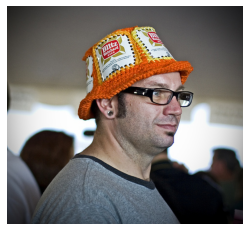

In [8]:
#IMG_PATH = "/content/drive/MyDrive/ai/Flicker8k_Dataset"
import cv2
import matplotlib.pyplot as plt
IMG_PATH="/content/drive/MyDrive/ai/Flicker8k_Dataset/"
img = cv2.imread(IMG_PATH+"1007129816_e794419615.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [9]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
   

In [11]:
(clean_text("A cat is sitting over ,the house # 64"))

'cat is sitting over the house'

In [12]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
       
        caption_list[i] = clean_text(caption_list[i])
        

In [14]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [15]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373837


In [16]:


import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))



8424


In [17]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [19]:
print(len(total_words))

1845


In [20]:
train_file_data = readTextFile("/content/drive/MyDrive/ai/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/MyDrive/ai/Flickr_8k.testImages.txt")

In [21]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [22]:


train[:5]



['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [23]:
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [24]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [25]:


model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()



102973440/102967424 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [26]:


model_new = Model(model.input,model.layers[-2].output)



In [27]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [28]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [29]:
encode_image("/content/drive/MyDrive/ai/Flicker8k_Dataset/1007129816_e794419615.jpg")

array([0.07020082, 0.4670934 , 0.        , ..., 0.01412497, 0.        ,
       0.04985615], dtype=float32)

In [30]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image
IMG_PATH="/content/drive/MyDrive/ai/Flicker8k_Dataset"
for ix,img_id in enumerate(train):
    img_path = "/content/drive/MyDrive/ai/Flicker8k_Dataset"+"/"+(img_id)+".jpg"
    print(img_path)
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/ai/Flicker8k_Dataset/491600485_26c52c8816.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/3079341641_f65f6b0f8b.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/3122938209_2b2c6c1fab.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/1095580424_76f0aa8a3e.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/3569284680_44fef444ef.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/3082196097_2d15455b00.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/2664102751_d5a737a566.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/1248734482_3038218f3b.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/2891240104_6755281868.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/2193223202_4d908c0450.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/2097407245_c798e0dcaf.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/2372572028_53b76104a9.jpg
/content/drive/MyDrive/ai/Flicker8k_Dataset/2930616480_7fd45ca79b.jpg
/content/drive/MyDrive/ai/Flicker8k_Data

In [33]:


# Store everything to the disk 
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)



In [34]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 334.4769883155823


In [35]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [36]:
# Vocab
len(total_words)

1845

In [37]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [38]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [39]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [40]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [41]:
f = open("/content/drive/MyDrive/glove.6B.50d.txt",encoding='utf8')

In [42]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [43]:
f.close()

In [44]:


embedding_index['mango']



array([ 0.26381 , -0.31832 , -1.0953  ,  1.3305  ,  0.24761 ,  0.045313,
       -0.39509 , -0.52107 , -0.016796,  0.33175 , -0.53252 ,  0.43263 ,
        1.2306  , -0.36963 ,  0.15989 , -0.433   , -0.29768 ,  0.768   ,
        0.71255 , -0.85675 , -0.076953, -1.0284  ,  0.9337  ,  0.24969 ,
       -0.13985 ,  1.0316  , -0.15809 ,  0.80512 ,  0.50535 , -0.50557 ,
        1.1237  , -0.45083 , -0.27552 ,  1.3537  ,  0.3553  ,  0.39403 ,
       -1.1213  ,  0.027925,  0.57582 , -0.63611 , -0.53506 , -0.080186,
       -0.78026 , -1.1595  ,  1.0318  ,  0.94337 ,  0.026387, -0.96839 ,
        0.54497 , -0.16479 ])

In [45]:


def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix



In [46]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [47]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [48]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [49]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [51]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [52]:


model.compile(loss='categorical_crossentropy',optimizer="adam")



In [54]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)

In [55]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [63]:
model = load_model('/content/drive/MyDrive/model_weights/model_9.h5')

In [64]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

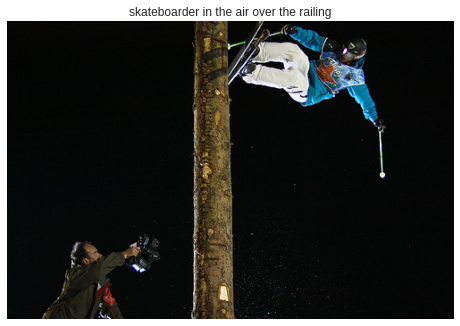

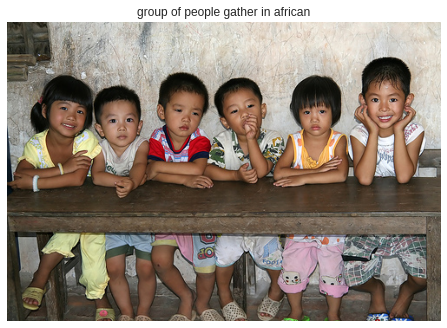

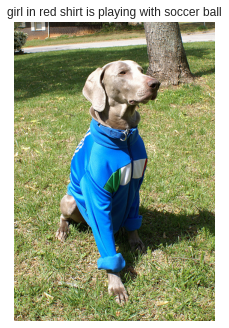

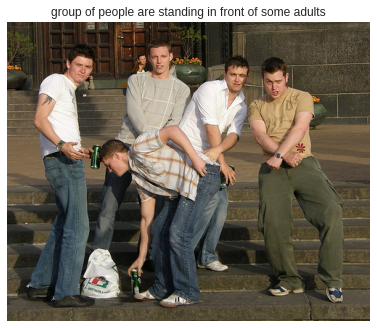

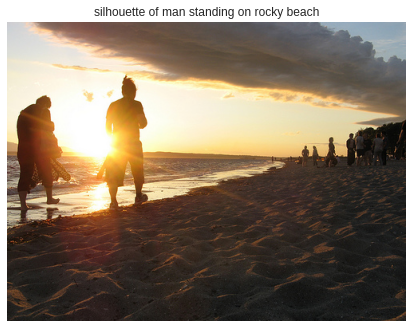

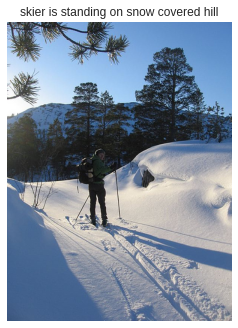

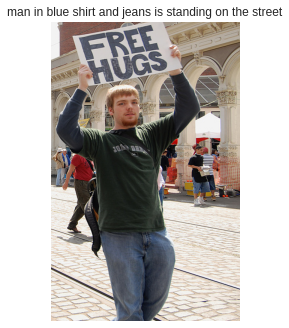

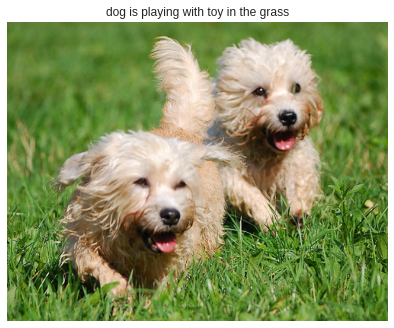

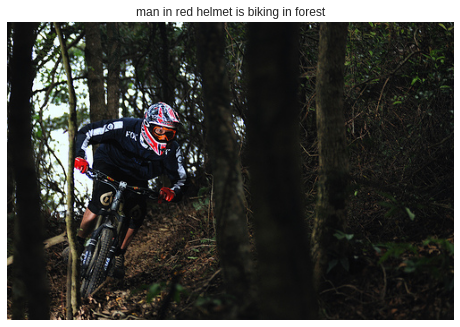

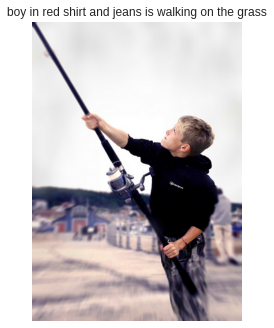

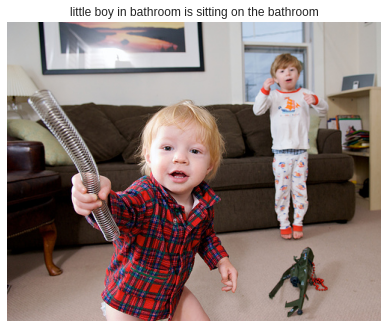

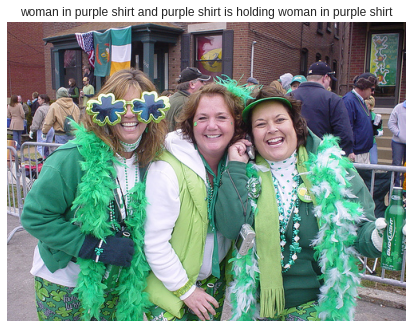

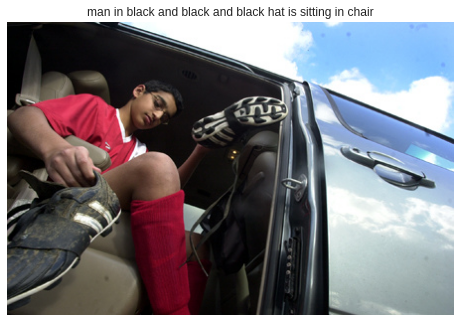

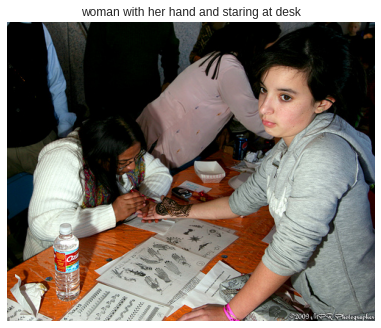

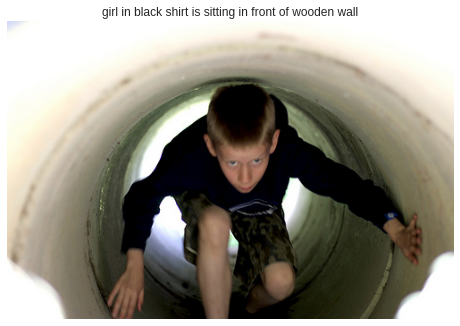

In [68]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/content/drive/MyDrive/ai/Flicker8k_Dataset/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()